In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torchsummary import summary

print(torch.__version__)

1.11.0+cu113


In [ ]:
# Hyper-parameters
learning_rate = 0.0001
n_epochs = 5
batch_size = 100
n_classes = 10
random_seed = 777

In [ ]:
# For Reproducibilty
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [ ]:
# Data 불러오기
data_dir = './data'

train_data = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transforms.Compose([transforms.Resize((224,224)), 
                                  transforms.ToTensor()])
)

val_data = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transforms.Compose([transforms.Resize((224,224)), 
                                  transforms.ToTensor()])
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [ ]:
val_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [ ]:
label_list = train_data.classes
label_list

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

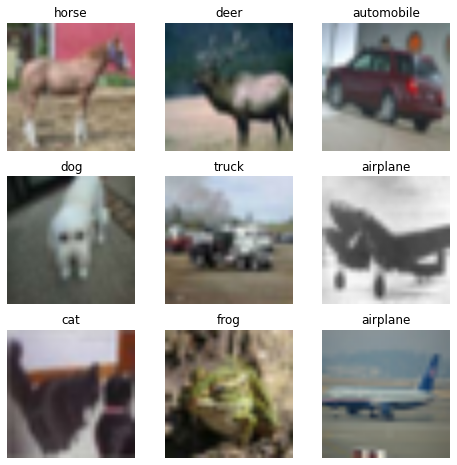

In [ ]:
# Data Visualization
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    img = img.permute(1,2,0)
    figure.add_subplot(rows, cols, i)
    plt.title(label_list[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [ ]:
# DataLoader 만들기
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

Feature batch shape: torch.Size([100, 3, 224, 224])
Labels batch shape: torch.Size([100])


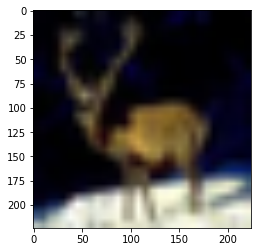

Label: deer(4)


In [ ]:
# DataLoader를 통해 반복하기(iterate)
# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1,2,0)
label = train_labels[0]
label_name = label_list[label]
plt.imshow(img)
plt.show()
print(f"Label: {label_name}({label})")

In [ ]:
# device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [ ]:
model = models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
print(model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
model.fc = nn.Linear(1024, n_classes)
model = model.to(device)

In [ ]:
print(model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [ ]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Optimizer
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

In [ ]:
# Train Function
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  n_batches = len(dataloader)
  model.train()
  train_loss = 0.
  for batch, (data, label) in enumerate(dataloader):
    data, label = data.to(device), label.to(device)
    pred = model(data)
    loss = loss_fn(pred, label)    

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  train_loss /= n_batches

  print(f"Training Loss: {train_loss:>8f}")

In [ ]:
# Validation Function
def val_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  n_batches = len(dataloader)
  model.eval()
  val_loss, correct = 0., 0
  with torch.no_grad():
    for data, label in dataloader:
      data, label = data.to(device), label.to(device)
      pred = model(data)
      val_loss += loss_fn(pred, label).item()
      correct += (pred.argmax(1) == label).type(torch.float).sum().item()
  val_loss /= n_batches
  correct /= size
  print(f"Validation Loss: {val_loss:>8f} Validation Accuracy: {(100*correct):>0.4f}%, \n")

In [ ]:
# 학습 진행하기
for epoch in range(n_epochs):
  print(f"<<Epoch {epoch+1}>>\n------------------------------------------------")
  train_loop(train_dataloader, model, loss_fn, optimizer)
  val_loop(val_dataloader, model, loss_fn)
print("Training Done!")

<<Epoch 1>>
------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Training Loss: 0.416967
Validation Loss: 0.187652 Validation Accuracy: 93.9300%, 

<<Epoch 2>>
------------------------------------------------
Training Loss: 0.109215
Validation Loss: 0.161377 Validation Accuracy: 94.8200%, 

<<Epoch 3>>
------------------------------------------------
Training Loss: 0.045275
Validation Loss: 0.177419 Validation Accuracy: 94.4500%, 

<<Epoch 4>>
------------------------------------------------


KeyboardInterrupt: ignored

In [ ]:
model2 = models.googlenet(pretrained=True)
model2.fc = nn.Linear(1024, n_classes)
model2 = model2.to(device)

In [ ]:
for idx, (name, param) in enumerate(model2.named_parameters()):
  print(idx, name)

0 conv1.conv.weight
1 conv1.bn.weight
2 conv1.bn.bias
3 conv2.conv.weight
4 conv2.bn.weight
5 conv2.bn.bias
6 conv3.conv.weight
7 conv3.bn.weight
8 conv3.bn.bias
9 inception3a.branch1.conv.weight
10 inception3a.branch1.bn.weight
11 inception3a.branch1.bn.bias
12 inception3a.branch2.0.conv.weight
13 inception3a.branch2.0.bn.weight
14 inception3a.branch2.0.bn.bias
15 inception3a.branch2.1.conv.weight
16 inception3a.branch2.1.bn.weight
17 inception3a.branch2.1.bn.bias
18 inception3a.branch3.0.conv.weight
19 inception3a.branch3.0.bn.weight
20 inception3a.branch3.0.bn.bias
21 inception3a.branch3.1.conv.weight
22 inception3a.branch3.1.bn.weight
23 inception3a.branch3.1.bn.bias
24 inception3a.branch4.1.conv.weight
25 inception3a.branch4.1.bn.weight
26 inception3a.branch4.1.bn.bias
27 inception3b.branch1.conv.weight
28 inception3b.branch1.bn.weight
29 inception3b.branch1.bn.bias
30 inception3b.branch2.0.conv.weight
31 inception3b.branch2.0.bn.weight
32 inception3b.branch2.0.bn.bias
33 inceptio

In [ ]:
for idx, (name, param) in enumerate(model2.named_parameters()):
  param.requires_grad = False
  if idx == 170:
    break

In [ ]:
model2.inception5b.branch4[1].bn.weight.requires_grad

False

In [ ]:
model2.fc.weight.requires_grad

True

In [ ]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(params=model2.parameters(), lr=learning_rate)

In [ ]:
# 학습 진행하기
for epoch in range(n_epochs):
  print(f"<<Epoch {epoch+1}>>\n------------------------------------------------")
  train_loop(train_dataloader, model2, loss_fn, optimizer)
  val_loop(val_dataloader, model2, loss_fn)
print("Training Done!")

<<Epoch 1>>
------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Training Loss: 1.759122
Validation Loss: 1.339798 Validation Accuracy: 70.9200%, 

<<Epoch 2>>
------------------------------------------------
Training Loss: 1.182782
Validation Loss: 1.022815 Validation Accuracy: 73.4200%, 

<<Epoch 3>>
------------------------------------------------
Training Loss: 0.979287
Validation Loss: 0.888166 Validation Accuracy: 74.6400%, 

<<Epoch 4>>
------------------------------------------------
Training Loss: 0.882138
Validation Loss: 0.821976 Validation Accuracy: 75.4500%, 

<<Epoch 5>>
------------------------------------------------
Training Loss: 0.825428
Validation Loss: 0.766075 Validation Accuracy: 76.4400%, 

Training Done!
